## Decision Trees

- Decision trees can perform classification, regression, and even multioutput tasks.
- They are powerful and can fit complex datasets.
- They are the fundamental components of random forests, which are among the most powerful machine learning algorithms available today.
- ***One of the many qualities of decision trees is that they require very little data preparation. In fact they don't require feature scaling or centering at all***.

In [49]:
# Build a decision tree classifier on the iris dataset
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [50]:
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

In [51]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [52]:
import platform

os_name = platform.system()
print(f"Current OS: {os_name}")

Current OS: Darwin


In [53]:
import os
if "win" in os_name.lower():
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
elif "darwin" in os_name.lower():
    os.environ["PATH"] += os.pathsep + "/usr/local/bin:/opt/homebrew/bin"


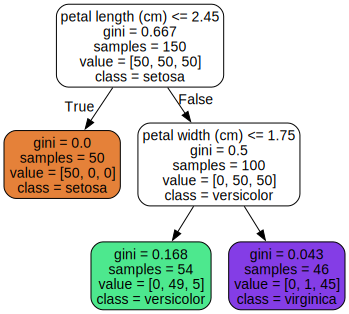

In [54]:
# Visualizing the trained tree
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf, 
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file("iris_tree.dot")

### Interpretation
- Suppose you find an iris flower and you want to classify it based on its petals.
    - You start at the *root node* (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45 cm.
    - If it is, then you move down to the root's left child node (depth 1, left).
        - In this case, it is a *leaf node* (i.e. it does not have any child nodes), so it does not ask any questions: simply look at the the predicted class for that node, and the decision tree predicts that your flower is an *Iris setosa* `(class=setosa)`.
- Now suppose you find another flower, and this time the petal length is greater than 2.45cm.
    - You again start at the root but now move down to its right child node (depth 1, right). 
    - This is not a leaf node, it's a *split node*, so it asks another question: is the petal width smaller than 1.75cm?
    - If it is, then your flower is most likely an *Iris versicolor* (depth 2, left).
    - If not, it is likely an *Iris virginica* (depth 2, right).

### Explaining the different fields in each node
- `samples`:
    - A node's `samples` attribute counts how many training instances it applies to.
    - For example, 100 training instances have a petal length greater than 2.45cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75cm (depth 2, left).
- `value`:
    - A node's `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor*, and 45 *Iris virginica*. 
- `gini`:
    - A node's `gini` attribute measures its *Gini impurity*: a node is "pure" `(gini=0)` if all training instances it applies to belong to the same class.
    - For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its Gini impurity is 0. 
    - *Gini impurity calculation of the ith node, where $k$ is the class:*
    $$
    G_i = 1 - \sum^n_{k=1}p_{i, k}^2
    $$
    - where:
        - $G_i$ is the Gini impurity of the $i^{th}$ node.
        - $p_{i, k}$ is the ratio of class $k$ instances among the instances in the $i^{th}$ node.
    - So the depth-2 left node has a Gini impurity of:
    $$
    1 - ( (\frac{0}{54})^2 + (\frac{49}{54})^2 + (\frac{5}{54})^2 ) \\
    = 1 - (0.8234 + 0.0086) \\
    = 1 - 0.832 \\
    \approx 0.168
    $$

***Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split nodes always have exactly two children (i.e., questions only have yes/no answers). However, other algorithms, such as ID3, can produce decision trees with nodes that have more than two children.***

### Model Interpretation: White Box vs Black Box
- Decision trees are intuitive, and their decisions are easy to interpret. Such models are often called *white box models*. 
- In contrast, random forests and neural networks are generally considered *black box models*: they make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made.
- For example, if a neural network says that a particular person appears in a picture, it is hard to know what contributed to this prediction: Did the model recognize that person's eyes? Their mouth? Their nose? Their shoes?
- Conversely, decision trees provide nice, simple classification rules that can be applied manually if need be.
- The field of ***interpretable ML*** aims at creating ML systems that can explain their decisions in a way humans can understand. .

### Estimating Class Probabilities
- A decision tree can also estimate the probability that an instance belongs to a particular class $k$. 
- First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. 
- Using the tree above, suppose you have found a flower whose petals are 5cm long and 1.5cm wide. 
    - The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities:
        - $0\%$ for *Iris setosa* $\frac{0}{54}$
        - $90.7\%$ for *Iris versicolor* $\frac{49}{54}$
        - $9.3\%$ for *Iris virginica* $\frac{5}{54}$
    - And if you ask it predict the class, it outputs *Iris versicolor* (class 1) because it has the highest probability.

### The CART Training Algorithm
- Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train decision trees (also called "growing trees").
- The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g. "petal length $\leq$ 2.45cm").
- How does it choose $k$ and $t_k$?
    - It searches for the pair ($k, t_k$) that produces the purest subsets, weighted by their size. 
    - The Equation below gives the cost function that the algorithm tries to minimize.
    $$
    J(k, t_k) = \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}} \\
    \text{where } \begin{cases}
        G_{\text{left/right}} \text{ measures the impurity of the left/right subset} \\ 
        m_{\text{left/right}} \text{ is the number of instances in the left/right subset} \\ 
    \end{cases}
    $$
- Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively.
- It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. 


### Computational Complexity
- Making predictions requires traversing the decision tree from the root to a leaf.
- Decision trees generally are approximately balanced, so traversing the decision tree requires going through roughly $O(\text{log}_2(m))$ nodes, where $\text{log}_2(m)$ is the *binary logarithm* of *m*, equal to $\frac{\text{log}(m)}{\text{log}(2)}$.
- Since each node only requires checking the value of one feature, the overall prediction complexity is $O(\text{log}_2(m))$, independent of the number of features.
- So predictions are very fast, even when dealing with large training sets.

### Gini Impurity or Entropy?
- By default, the `DecisionTreeClassifier` class uses the Gini impurity measure, but you can select the *entropy* impurity measure instead by setting the `criterion` hyperparameter to "entropy".
- A set's entropy is zero when it contains instances of only one class. 
- Equation for the Entropy of the $i^{th}$ node
$$
H_i = - \sum^n_{\underset{p_{i, k} \neq 0}{k=1}} p_{i, k} \text{ log}_2(p_{i, k})
$$
- For example, the depth-2 left node in the original tree graph has an entropy equal to:
$$
-[(\frac{49}{54} \text{log}_2(\frac{49}{54})) + (\frac{5}{54} \text{log}_2(\frac{5}{54}))] \\
= - (-0.127198 + -0.317867) \\ 
\approx 0.445065
$$
- It often does not matter much if you use Gini impurity or entropy.
    - Gini impurity is slightly faster so it is a good default.
    - However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

### Regularization Hyperparameters
- If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely - indeed, most likely overfitting it. 
- Such a model is called a *nonparametric model* because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data (A *parametric model* such as a linear model, has a predetermined number of parameters so its degree of freedom is limited, reducing the risk of overfitting).
- To avoid overfitting, you need to regularize the decision tree. 
- There a few parameters which can be altered to achieve regularization (or make the model more powerful if necessary):
    - Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting. 
    - `max_features`
        - Maximum number of features that are evaluated for splitting at each node.
    - `max_leaf_nodes`
        - Maximum number of leaf nodes
    - `min_samples_split`
        - Minimum number of samples a node must have before it can be split
    - `min_samples_leaf`
        - Minimum number of samples a leaf node must have to be created
    - `min_weight_fraction_leaf`
        - Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances.
- ***Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.***


In [55]:
# Testing regularization on the moons dataset
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

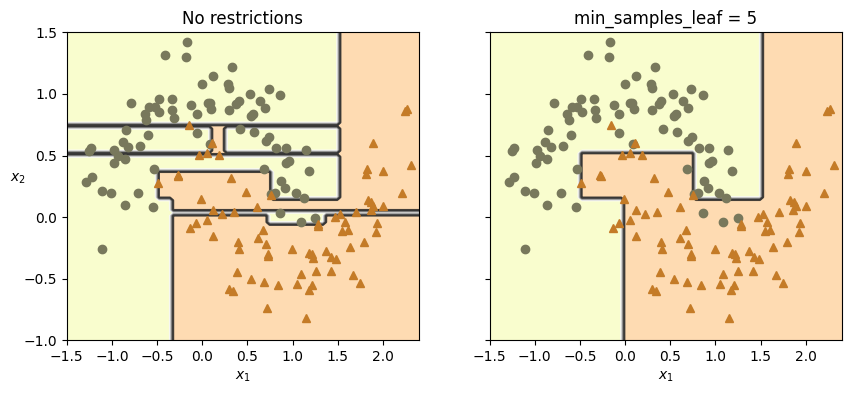

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

- The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better.
- We can verify this by evaluating both trees on a test set generated using a different random seed.

In [57]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

print(tree_clf1.score(X_moons_test, y_moons_test))
print(tree_clf2.score(X_moons_test, y_moons_test))

0.898
0.92


Indeed, the second tree has a better accuracy on the test set.

### Regression
- Decision trees are also capable of performing regression tasks.
- The CART algorithm works as described earlier, except that instead of trying to split the training set in a way that minimizes the impurity, it now tries split the training set in a way that minimizes the MSE. 
- Cost function that the decision tree regression model tries to minimize:
$$
J(k, t_k) = \frac{m_\text{left}}{m} \text{MSE}_\text{left} + \frac{m_\text{right}}{m} \text{MSE}_\text{right} \\
\text{where } \begin{cases}
\text{MSE}_\text{node} = \frac{\sum_{i \epsilon \text{ node}}(\hat{y}_\text{node} - y^{(i)})^2}{m_\text{node}} \\
\hat{y}_\text{node} = \frac{\sum_{i \epsilon \text{ node }} y^{(i)}}{m_\text{node}} \\
\end{cases}
$$

In [58]:
# Building a regression tree and training it on a noisy quadratic dataset.
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5 # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

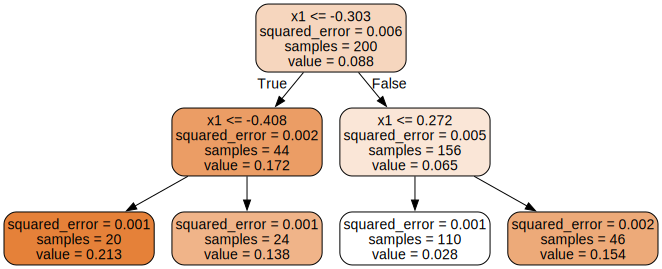

In [59]:
export_graphviz(
    tree_reg, 
    out_file="quad_reg_tree.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True,
    impurity=True
)

Source.from_file("quad_reg_tree.dot")

- Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks. 

### Sensitivity to Axis Oreientation
- Decision trees love orthogonal decision boundaries (all splits are perpendicular to an axis). This makes them sensitive to the data's orientation.
- One way to limit this problem is to scale the data, then apply a principal component analysis (PCA) transformation.
    - Basically, it rotates the data in a way that reduces the correlation between the features, which often (not always) makes things easier for trees.

In [60]:
# Create a pipeline that scales the data and rotates it using PCA
# Then train a DecisionTreeClassifier on that data
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

In [61]:
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
X_iris_rotated

array([[-1.87784285e+00,  1.75236840e-02],
       [-1.87784285e+00,  1.75236840e-02],
       [-1.91803298e+00,  5.77138140e-02],
       [-1.83765272e+00, -2.26664460e-02],
       [-1.87784285e+00,  1.75236840e-02],
       [-1.57111644e+00,  8.31093143e-02],
       [-1.78476484e+00,  1.10601694e-01],
       [-1.83765272e+00, -2.26664460e-02],
       [-1.87784285e+00,  1.75236840e-02],
       [-1.93073073e+00, -1.15744456e-01],
       [-1.83765272e+00, -2.26664460e-02],
       [-1.79746259e+00, -6.28565760e-02],
       [-1.97092086e+00, -7.55543261e-02],
       [-2.09149125e+00,  4.50160639e-02],
       [-1.95822311e+00,  9.79039440e-02],
       [-1.65149670e+00,  1.63489574e-01],
       [-1.73187696e+00,  2.43869834e-01],
       [-1.78476484e+00,  1.10601694e-01],
       [-1.66419445e+00, -9.96869583e-03],
       [-1.74457471e+00,  7.04115642e-02],
       [-1.75727246e+00, -1.03046706e-01],
       [-1.65149670e+00,  1.63489574e-01],
       [-2.03860337e+00,  1.78284204e-01],
       [-1.

In [62]:
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

### Decision Trees Have a High Variance
- The main issue with decision trees is that they have quite a high variance: *small changes to the hyperparameters or to the data may produce very different models.*
- Since the training algorithm used by scikit-learn is stochastic (it randomly selects the set of features to evaluate at each node) even retraining the same decision tree on the exact same data my produce a very different model (unless you set the `random_state` hyperparameter).
- Luckily, by averaging predictions over many trees, it's possible to reduce variance significantly.
    - Such an *ensemble* of trees is called a *random forest*, and it is one of the most powerful types of models available today.